In [1]:
import numpy as np
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from numpy.lib.function_base import cov

In [19]:
n = 0
m = 3*n
eps = 0.1
data_dim = 2
mu = 0
mu_out = 5
par_mu = np.full(data_dim, mu)
par_sd = np.eye(data_dim)
out_mu = np.full(data_dim, mu_out)
true_alpha = [par_mu, par_sd]

exper_iter = 5
optim_iter = 100
L = 100
learn_par = 1
dicay_par = 0.5

def sigmoid(x):
    return 1/(np.exp(-x) + 1)

def deriv_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def g_up(t, s):
    return sigmoid(s) + deriv_sigmoid(s)*(t-s) + (t-s)**2/20

def g_lo(t, s):
    return sigmoid(s) + deriv_sigmoid(s)*(t-s) - (t-s)**2/20



def create_out_cov(data_dim):
    return_cov = np.zeros([data_dim, data_dim])
    for i in range(data_dim):
        for j in range(i+1):
            z = np.random.uniform(0.4, 0.8)
            gamma = np.random.binomial(n = 1,p=0.1)
            return_cov[i][j] = z*gamma
            return_cov[j][i] = z*gamma
    return_cov = return_cov +(np.abs(np.linalg.eig(return_cov)[0]) +0.05)*np.eye(data_dim)
    return return_cov

In [20]:
# 分散を固定しない
out_cov = create_out_cov(data_dim)
res = [0 for i in range(exper_iter)]
for i in range(exper_iter):
    n+=200
    m = 3*n
    print("%d/%d" %(i+1, exper_iter))
    data = np.random.multivariate_normal(mean = par_mu, cov = par_sd, size = int(n*(1-eps)))
    # Gaoの論文の設定
    contamination = np.random.multivariate_normal(mean = out_mu, cov = out_cov, size = (n - int(n*(1-eps))))
    data = np.concatenate([data, contamination])
    np.random.shuffle(data)
    alpha_hist = []
    cov_hist = []
    # 平均は次元ごとにロバスト、分散はロバストでない
    alpha = [np.median(data, axis=0), np.cov(data, rowvar = False)]
    for j in tqdm(range(1, optim_iter+1)):
        z = np.random.multivariate_normal(mean=alpha[0], cov=alpha[1], size = m)
        def major_func(par, past_par):
            new_beta = par[0:2*data_dim]; new_b = par[2*data_dim]; beta = past_par[0:2*data_dim]; b = past_par[2*data_dim]
            A = np.mean(g_lo(np.dot(np.stack([z, z**2], axis=1).reshape(m, 2*data_dim),new_beta) - new_b, np.dot(np.stack([z, z**2], axis=1).reshape(m, 2*data_dim),beta) - b))
            B = np.mean(g_up(np.dot(np.stack([data, data**2], axis=1).reshape(n, 2*data_dim),new_beta) - new_b, np.dot(np.stack([data, data**2], axis=1).reshape(n, 2*data_dim),beta) - b))
            return -(A-B)

        l = 0; par = np.random.normal(scale = 0.1, size = 2*data_dim + 1)
        while(l<L):
            op = minimize(major_func, x0 = np.zeros(2*data_dim +1), args = par)
            par = op.x
            l+=1
        
        alpha_m = alpha[0]; alpha_v = alpha[1]
        mgrad = (z-alpha_m)
        sigma_grad = z[:,:,np.newaxis] * z[:, np.newaxis, :] - alpha_v
        sig_ = sigmoid(np.dot(np.stack([z, z**2], axis=1).reshape(m, 2*data_dim),par[0:2*data_dim ])- par[2*data_dim])[:,np.newaxis]
        tmp_alpha_m = alpha[0] - learn_par/j**dicay_par * np.mean(mgrad*sig_, axis = 0)
        tmp_alpha_v = alpha[1] - learn_par/j**dicay_par * np.mean(sigma_grad*sig_[:,:,np.newaxis], axis = 0)
        alpha[0], alpha[1] = tmp_alpha_m, tmp_alpha_v
        alpha_hist.append(alpha[0])
        cov_hist.append(alpha[1])
    res[i] = [alpha_hist, cov_hist]



1/5


100%|██████████| 100/100 [02:16<00:00,  1.37s/it]


2/5


100%|██████████| 100/100 [02:51<00:00,  1.71s/it]


3/5


100%|██████████| 100/100 [03:26<00:00,  2.07s/it]


4/5


100%|██████████| 100/100 [03:59<00:00,  2.39s/it]


5/5


100%|██████████| 100/100 [04:25<00:00,  2.65s/it]


In [16]:
def calc_op_norm(cov):
    return np.max(np.linalg.eig(cov)[0])

def calc_f_norm(cov):
    return np.sum(cov**2)

1.7573244361749731
1.4188845045188634
1.3539289857170447
1.3966255737261517
1.5018563690201256


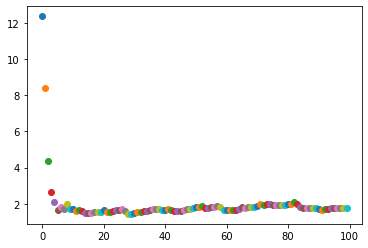

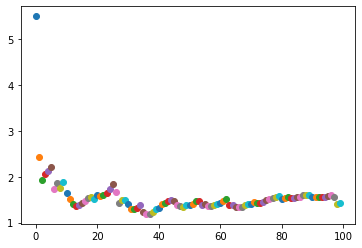

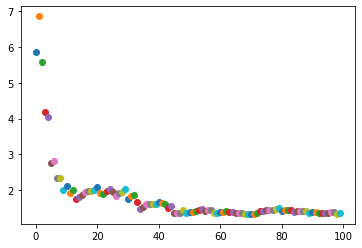

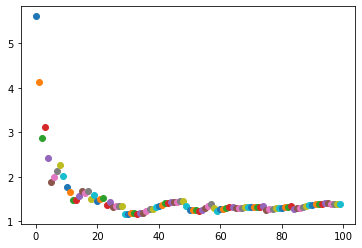

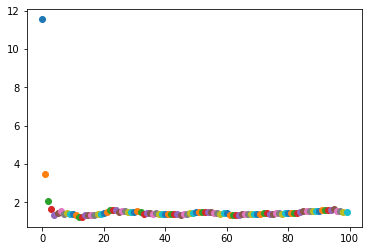

In [24]:
#optim, mm = (100, 100) n = 200,400,..,1000
for j in range(exper_iter):
    plt.subplots()
    mean = np.array(res[j][0])
    cov = np.array(res[j][1])
    for i in range(optim_iter):
        op_norm = np.abs(calc_f_norm(cov[i] - out_cov))
        plt.scatter(i, op_norm)
    print(np.abs(calc_f_norm(cov[-1] - out_cov)))

1.209869846892484
0.9156735326250945
0.9962094469123342
1.0342222941283405
1.109661054237797


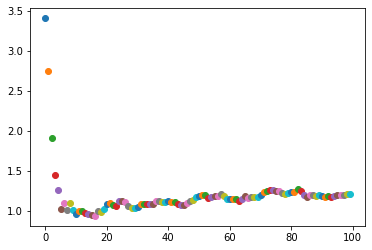

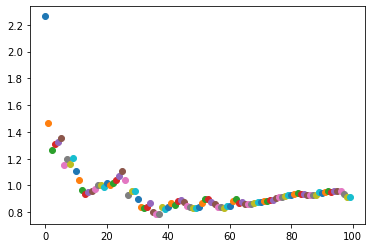

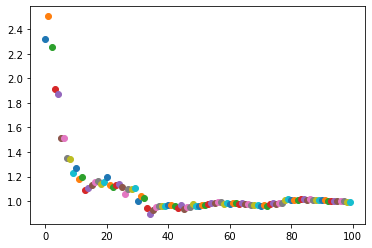

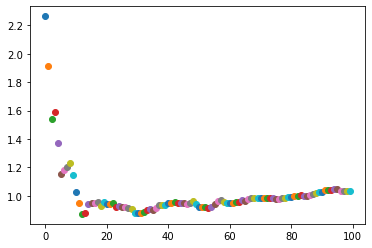

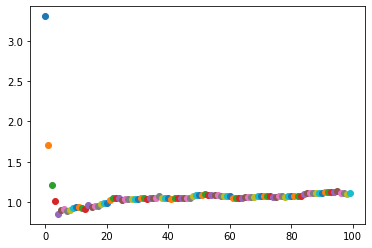

In [23]:
#optim, mm = (100, 100) n = 200,400,..,1000
for j in range(exper_iter):
    plt.subplots()
    mean = np.array(res[j][0])
    cov = np.array(res[j][1])
    for i in range(optim_iter):
        op_norm = np.abs(calc_op_norm(cov[i] - out_cov))
        plt.scatter(i, op_norm)
    print(np.abs(calc_op_norm(cov[-1] - out_cov)))

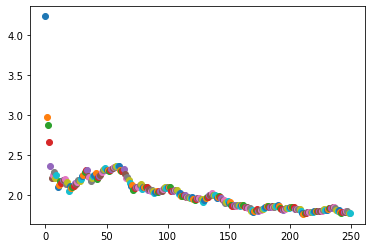

In [ ]:
mean = np.array(res[0][0])
cov = np.array(res[0][1])
#optim, mm = (250, 25)
for i in range(optim_iter):
    op_norm = np.abs(calc_op_norm(cov[i] - out_cov))
    plt.scatter(i, op_norm)

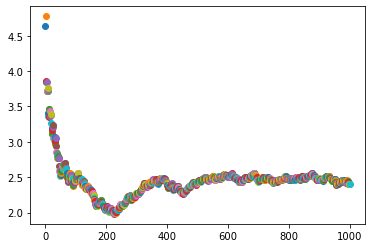

In [30]:
mean = np.array(res[0][0])
cov = np.array(res[0][1])
#optim, mm = (1000, 5)
for i in range(optim_iter):
    op_norm = np.abs(calc_op_norm(cov[i] - out_cov))
    plt.scatter(i, op_norm)

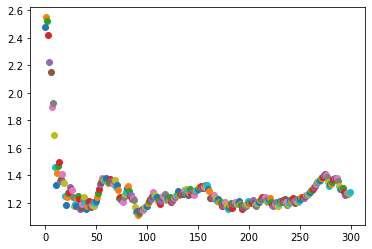

In [27]:
mean = np.array(res[0][0])
cov = np.array(res[0][1])
#optim, mm = (300, 10)
for i in range(optim_iter):
    op_norm = np.abs(calc_op_norm(cov[i] - out_cov))
    plt.scatter(i, op_norm)

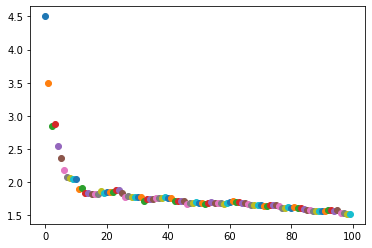

In [24]:
mean = np.array(res[0][0])
cov = np.array(res[0][1])
#optim, mm = (100, 100)
for i in range(optim_iter):
    op_norm = np.abs(calc_op_norm(cov[i] - out_cov))
    plt.scatter(i, op_norm)